In [46]:
#https://machinelearningmastery.com/xgboost-for-time-series-forecasting/?unapproved=601592&moderation-hash=d98f616a2939421833382d1e7772df57#comment-601592
import os
import time
import pandas as pd
from matplotlib import pyplot
import numpy as np
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

params = {
    "learning_rate" : [0.05, 0.1, 0.15, 0.20, 0.25, 0.3],
    "max_depth" : [3,4,5,6,8,10,12,15],
    "main_child_weight" : [1,2 ,3],
    "gamma" : [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

param_grid = {
        'silent': [False],
        'max_depth': [3,4,6,8, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

In [47]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators= 1500,
                         learning_rate=0.02 ,max_depth=8) # learning_rate=0.001, verbosity=0, booster="")
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

    #regressor = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    #random_search = RandomizedSearchCV(regressor, param_distributions=params, scoring="neg_mean_squared_error", n_jobs=-1, verbose=3)
    #random_search.fit(trainX, trainy)
    #random_search.best_estimator_
    #random_search.best_params_
    #yhat = regressor.predict(asarray[testX])
    #return yhat[0]

    # reg = XGBRegressor()
    # reg_rs = RandomizedSearchCV(reg, param_grid, n_iter=20,
    #                         n_jobs=1, verbose=2, cv=2,
    #                         scoring='neg_log_loss', refit=False, random_state=42)
    # print("Randomized search..")
    # search_time_start = time.time()
    # reg_rs.fit(trainX, trainy)
    # print("Randomized search time:", time.time() - search_time_start)
    #
    # best_score = reg_rs.best_score_
    # best_params = reg_rs.best_params_
    # print("Best score: {}".format(best_score))
    # print("Best params: ")
    # for param_name in sorted(best_params.keys()):
    #     print('%s: %r' % (param_name, best_params[param_name]))

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [48]:
# load the dataset
file = "C:/Users/gurpr/Videos/BetaSci/Rossmann_Store1_Data_FULL.csv"
pwd = os.getcwd()
os.chdir(os.path.dirname(file))
series = read_csv('Rossmann_Store1_Data_FULL.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning and use n_in previous time steps
data = series_to_supervised(values, n_in=584)

In [49]:
print(series.shape)
print(values.shape)
print(data.shape)

#n_in: 1 en n_test 100 ==> MAE: 548.457
#n_in: 584 en n_test 195 ==> MAE: 669.020
#n_in: 1 and n_test 195 ==> MAE: 769.970

(780, 1)
(780, 1)
(196, 585)


C:\Users\gurpr\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MAE: 638.965


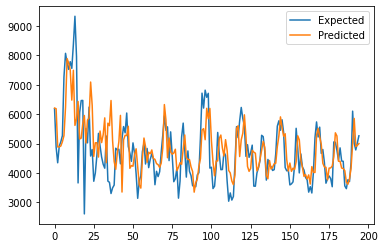

In [50]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 195)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [52]:
out = np.array(yhat, dtype=int)
out.round()
print(out)
df = pd.DataFrame({'Predicted Sales': out})
df.to_csv(r'C:\Users\gurpr\Videos\BetaSci\Xgboost_win30_n-est1,5k_depth8_l-rate0.02.csv', index=False, header=True)

[6206 6184 4883 4883 4914 5059 5268 6228 7890 7738 7501 6477 7492 5617
 5839 6431 5153 5182 5680 5954 5018 5796 5866 7092 6293 4561 5026 5026
 4539 5425 5031 5298 5872 4348 5692 5608 6463 5094 4388 4123 4670 5063
 5957 3349 5127 5282 5268 5586 4156 4249 4227 4619 4820 4187 3595 3483
 4487 5186 4892 4360 4703 4651 4781 4492 4459 4317 4281 4184 4335 4851
 6325 5803 4516 5187 4714 4636 4675 4805 4074 4193 4348 4294 4818 5290
 4523 4455 4453 4204 4048 3345 3667 3787 4218 4487 5457 5505 5130 6197
 5845 6193 5086 4367 3901 4402 4409 5177 5288 4843 4575 5131 4770 4083
 3998 3725 3599 3931 5508 5604 4557 5126 5349 5976 5234 4220 4053 4152
 4770 4706 4672 4068 4195 4468 4775 5073 4872 3907 3801 4422 4132 4199
 4312 4331 4896 5264 5906 5551 5250 5333 4449 4064 4335 4053 4162 4117
 4381 5264 5127 4443 4189 3882 3942 3795 3931 3620 4214 4022 4015 5285
 5517 5229 4978 4330 4202 4190 3763 4163 4169 4235 4546 5364 5254 4397
 4396 4164 4149 4076 3684 3615 3801 4157 4978 5853 4894 4937 4997]
